# Regression Model
Perry Chu

In [1]:
import datetime
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats as stats

% matplotlib inline

sns.set()


/home/perry/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1) Data import & cleaning


### Import & initial transform

In [2]:
df = None

#Import data
with open("kick_data.csv","r") as f_in:
    df = pd.read_csv(f_in)


def project_status_calc(row):
    if row.funding_end.date() > datetime.datetime(2018,1,30).date():
        return "Live"
    elif row.dollar_goal > row.dollar_total:
        return "Fail"
    else:
        return "Success"

def funding_days_calc(row):
    if row.funding_days == -1:
        return (row.funding_end - row.funding_start).days
    else:
        return row.funding_days

#Format date string as datetime 
df["funding_start"] = pd.to_datetime(df.funding_start,format="%Y-%m-%d",errors="coerce")
df["funding_end"] = pd.to_datetime(df.funding_end,format="%Y-%m-%d",errors="coerce")

#Fill funding_days if missing
df["funding_days"] = df.apply(funding_days_calc, axis = 1)

#Calc new stats
df["project_status"] = df.apply(project_status_calc, axis=1)
df["backers_US_pct"] = df.backers_US / df.backers_total
df["backers_new_pct"] = df.backers_new / df.backers_total
df["funding_start_month"] = df.funding_start.dt.month
df["funding_end_month"] = df.funding_end.dt.month

#Basic stats
print (len(df), "samples in data frame\n")
print ("Project types:")
print (df.project_status.value_counts())

#Manually initializing these here so I can skip running every cell
#Thought process + operations (to narrow to these columns) below 
columns_target = ['dollar_total', 'backers_total','backers_US']
columns_data = ['activity_comment_total', 'activity_faq_end','activity_update_end', 
                'creator_backed', 'creator_projects', 'dollar_goal','funding_days', 
                'reward_count', 'reward_min', 'reward_max', 'reward_median', 'reward_mode_cost',
                'backers_US_pct', 'backers_new_pct', 'funding_end_month']

print (df.columns)

5044 samples in data frame

Project types:
Fail       2491
Success    2417
Live        136
Name: project_status, dtype: int64
Index(['url', 'project_name', 'activity_comment_total', 'activity_faq_end',
       'activity_faq_total', 'activity_update_end', 'activity_update_total',
       'backers_US', 'backers_total', 'backers_exist', 'backers_new',
       'creator_backed', 'creator_projects', 'dollar_goal', 'dollar_total',
       'funding_days', 'funding_end', 'funding_start', 'reward_count',
       'reward_max', 'reward_mean', 'reward_median', 'reward_min',
       'reward_mode_backers', 'reward_mode_cost', 'project_status',
       'backers_US_pct', 'backers_new_pct', 'funding_start_month',
       'funding_end_month'],
      dtype='object')


In [3]:
#df.info()

### Data cleaning: Dependent / target vars

dollar_total  backers_total    backers_US
count  5.044000e+03    5044.000000   5044.000000
mean   3.671266e+04     474.044607    298.247819
std    2.581541e+05    2201.751718   1342.061641
min    0.000000e+00       0.000000     -1.000000
10%    1.390000e+02       5.000000     -1.000000
30%    1.114000e+03      27.000000     20.000000
50%    3.438500e+03      77.000000     59.000000
70%    1.001000e+04     204.000000    153.000000
90%    4.559070e+04     904.800000    601.700000
max    1.239314e+07   85581.000000  56942.000000

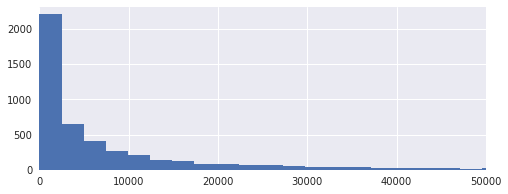

In [4]:
plt.figure(figsize=(8,3))
plt.hist(df.dollar_total,bins=5000)
plt.xlim(0,50000)

#sns.distplot(df.dollar_total)

df[columns_target].describe(percentiles=[.1,.3,.5,.7,.9])

#### Dollar total

411 projects with <= $100 pledged
713 projects with <= $250 pledged
1011 projects with <= $500 pledged
1429 projects with <= $1000 pledged
1978 projects with <= $2000 pledged

----

mean: 36712.66
standard deviation: 258128.55
3x std:774385.64
values > 3x std: 34


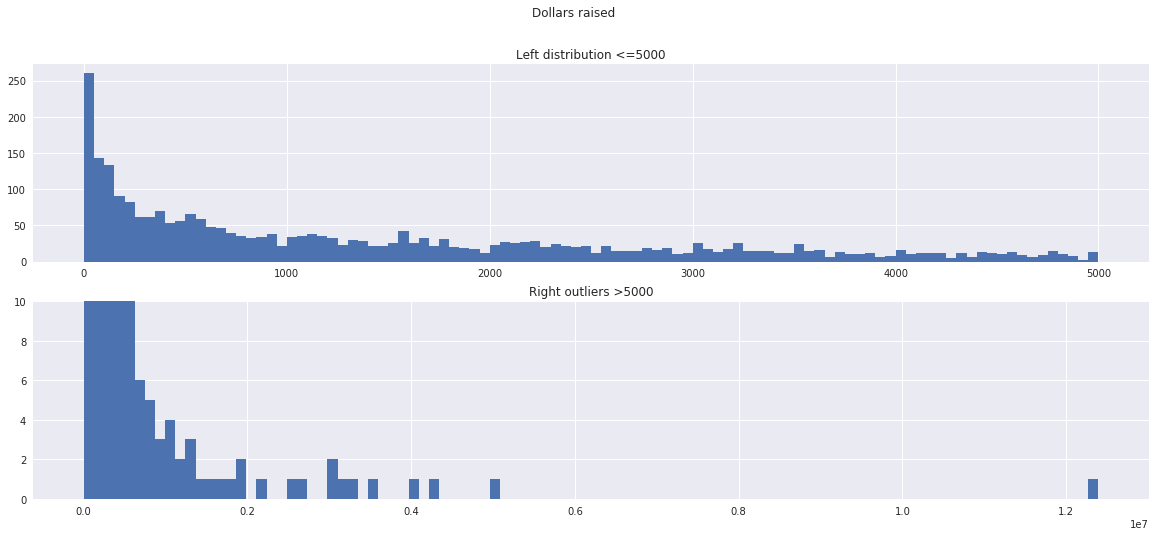

In [5]:
print(len(df[df.dollar_total <= 100]), "projects with <= $100 pledged")
print(len(df[df.dollar_total <= 250]), "projects with <= $250 pledged")
print(len(df[df.dollar_total <= 500]), "projects with <= $500 pledged")
print(len(df[df.dollar_total <= 1000]), "projects with <= $1000 pledged")
print(len(df[df.dollar_total <= 2000]), "projects with <= $2000 pledged")

x_axis = 5000

fig, ax = plt.subplots(2,1)
fig.set_size_inches(20,8)
fig.suptitle("Dollars raised")

ax[0].set_title("Left distribution <=%d" % x_axis)
ax[1].set_title("Right outliers >%d" % x_axis)
ax[0].hist(df[df.dollar_total<=x_axis].dollar_total,bins=100)
ax[1].set_ylim(0,10)
ax[1].hist(df[df.dollar_total>x_axis].dollar_total,bins=100);

print("\n----\n")
sd = np.std(df.dollar_total)
limit = 3
print("mean: {:.2f}".format(np.mean(df.dollar_total)))
print("standard deviation: {:.2f}".format(sd))
print("{}x std:{:.2f}".format(limit,limit*sd))
print("values > {}x std: {}".format(limit, len(df[df.dollar_total>limit*sd])))

#### Backers 

43 projects with no backers
245 projects with <=2 backer
528 projects with <=5 backer
902 projects with <=10 backer
1341 projects with <=20 backer
1617 projects with <=30 backer

----

mean: 474.0446074544013
standard deviation: 2201.5334526220904
3x std: 6604.600357866271
values > 3x std: 52


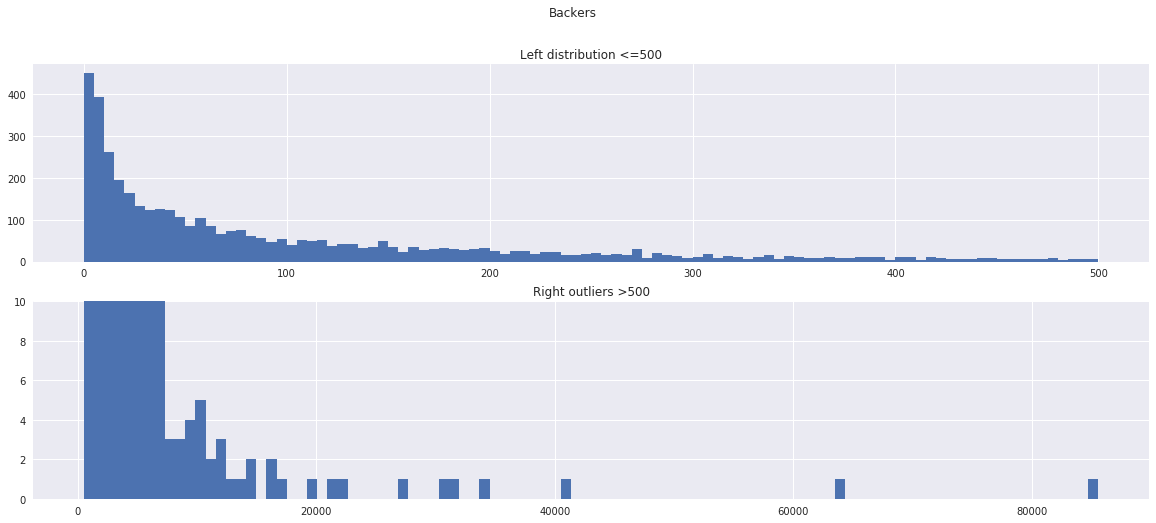

In [6]:
print(len(df[df.backers_total == 0]), "projects with no backers")
print(len(df[df.backers_total <= 2]), "projects with <=2 backer")
print(len(df[df.backers_total <= 5]), "projects with <=5 backer")
print(len(df[df.backers_total <= 10]), "projects with <=10 backer")
print(len(df[df.backers_total <= 20]), "projects with <=20 backer")
print(len(df[df.backers_total <= 30]), "projects with <=30 backer")

x_axis = 500

fig, ax = plt.subplots(2,1)
fig.set_size_inches(20,8)
fig.suptitle("Backers")

ax[0].set_title("Left distribution <=%d" % x_axis)
ax[1].set_title("Right outliers >%d" % x_axis)
ax[0].hist(df[df.backers_total<=x_axis].backers_total,bins=100)
ax[1].set_ylim(0,10)
ax[1].hist(df[df.backers_total>x_axis].backers_total,bins=100);

print("\n----\n")
sd = np.std(df.backers_total)
limit = 3
print("mean:", np.mean(df.backers_total))
print("standard deviation:",sd)
print("%dx std:" % limit,limit*sd)
print("values > %dx std:" % limit, len(df[df.backers_total>limit*sd]))

#### Look at data points removed

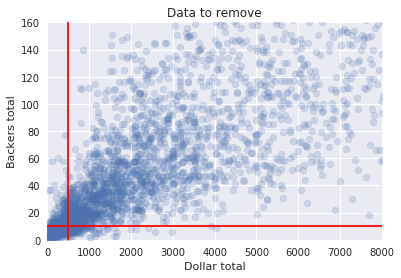

In [7]:
plt.scatter(df["dollar_total"],df["backers_total"], alpha=.2)
plt.plot([0,10000],[10,10],"r")
plt.plot([500,500],[0,10000],"r")
plt.xlim(0,8000)
plt.ylim(0,160)
plt.title("Data to remove")
plt.xlabel("Dollar total")
plt.ylabel("Backers total")
plt.show()

#### Data cleanup - target vars
Remove inactive projects (near 0 raised / backed) and active outliers (> 3x standard dev)

In [8]:
print("removing:\n",
      len(df[df.backers_total <= 10]),"backers <= 10\n", 
      len(df[df.dollar_total <= 500]),"dollar_total <= 500\n",
      len(df[(df.backers_total <= 10)|(df.dollar_total <= 500)]), "combined total\n"
     )

df = df[df.backers_total > 10]
df = df[df.dollar_total > 500]

print (len(df), "samples in data frame")
print("\n-------\n")

print("removing:\n",
      len(df[df.backers_total > 6604]),"backers > 11007 (3x std dev) \n", 
      len(df[df.dollar_total > 774385]),"dollar_total > 1290642 (3x std dev )\n",
      len(df[(df.backers_total  > 6604)|(df.dollar_total > 774385)]), "combined total\n"
     )

df = df[df.backers_total <= 6604]
df = df[df.dollar_total <= 774385]

print (len(df), "samples in data frame\n")
print ("Project types:")
print (df.project_status.value_counts())

removing:
 902 backers <= 10
 1011 dollar_total <= 500
 1122 combined total

3922 samples in data frame

-------

removing:
 52 backers > 11007 (3x std dev) 
 34 dollar_total > 1290642 (3x std dev )
 64 combined total

3858 samples in data frame

Project types:
Success    2293
Fail       1465
Live        100
Name: project_status, dtype: int64


### Data cleaning: Independent / input vars

#### Columns to exclude (intuition):
- **activity_faq_total, activity_update_total:** includes data after project funding ends
  - **activity_comment_total:** should exclude also, but I don't have a value that counts "during project"
- **backers_US, backers_exist, backers_new:** Using the % based columns instead. Absolute vals correlate with backers_total, and not collectable before funding closes. % based columns can suggest a ratio for projects to target
- **rewards_mode_backers:** not collectable before funding closes
- **rewards_mean:** expresses same idea as rewards_median (and maybe reward_mode_cost)
- **funding_start_month:** expresses same idea as funding_end_month (funding days is pretty standard across projects). End month might have a stronger signal (e.g. end of year before holidays)

In [9]:
columns_exclude = ["activity_faq_total", "activity_update_total", 
                   "backers_US", "backers_exist", "backers_new",
                   "rewards_mode_backers","rewards_mean",
                   "funding_start_month"
                  ]

columns_data_updated = [x for x in columns_data if x not in columns_exclude]

#test
#print (columns_data, columns_data_update)
#assert(columns_data_update == columns_data)

columns_data = columns_data_updated

#### Descriptive stats

- Dollar_goal, reward_min, and reward_mode_cost seem to have strange max values  
  - dollar_goal -> Minimum funding threshold for project
  - reward_min -> cost of lowest reward tier
  - reward_mode_cost -> cost of most commonly backed reward tier (usually 1 copy of the game / project)
- Backers_new_pct has some negative values (scraper returned -1 for not found)


In [10]:
df[columns_data].iloc[:,:7].describe(percentiles=[.05,.25,.5,.75,.95])

activity_comment_total  activity_faq_end  activity_update_end  \
count             3858.000000       3858.000000          3858.000000   
mean               228.685329          1.554173             7.928979   
std               1160.283834          2.907492             7.206725   
min                  0.000000          0.000000             0.000000   
5%                   0.000000          0.000000             0.000000   
25%                  7.000000          0.000000             3.000000   
50%                 30.000000          0.000000             6.000000   
75%                119.000000          2.000000            10.750000   
95%                857.150000          7.000000            21.000000   
max              46351.000000         37.000000            64.000000   

       creator_backed  creator_projects   dollar_goal  funding_days  
count     3858.000000       3858.000000  3.858000e+03   3858.000000  
mean        39.973821          5.617418  1.355057e+04     29.324780  
std         69.958235          8.887761  3.746147e+04      8.742241  
min          0.000000          1.000000  1.000000e+00      2.000000  
5%           0.000000          1.000000  5.000000e+02     14.000000  
25%          3.000000          1.000000  3.000000e+03     28.000000  
50%         14.000000          2.000000  7.500000e+03     30.000000  
75%         47.000000          6.000000  1.500000e+04     31.000000  
95%        178.000000         24.000000  4.102850e+04     45.000000  
max        869.000000         83.000000  1.949000e+06     60.000000

In [11]:
df[columns_data].iloc[:,7:].describe(percentiles=[.05,.25,.5,.75,.95])

reward_count   reward_min    reward_max  reward_median  \
count   3858.000000  3858.000000   3858.000000    3858.000000   
mean       8.451529     8.105754    781.660705      65.179497   
std        5.266687    19.072130   1711.483033     116.759913   
min        1.000000     0.000000      1.000000       1.000000   
5%         3.000000     1.000000     30.000000      15.000000   
25%        5.000000     1.000000    100.000000      30.000000   
50%        7.000000     1.000000    239.000000      45.000000   
75%       10.000000    10.000000    500.000000      75.000000   
95%       18.000000    30.000000   4000.000000     155.000000   
max       77.000000   550.000000  10000.000000    5000.000000   

       reward_mode_cost  backers_US_pct  backers_new_pct  funding_end_month  
count       3858.000000     3858.000000      3858.000000        3858.000000  
mean          37.278383        0.749642         0.141137           6.736651  
std           43.503906        0.134914         0.170882           3.373878  
min            1.000000       -0.076923         0.000000           1.000000  
5%             6.000000        0.519783         0.000000           2.000000  
25%           18.000000        0.668925         0.027505           4.000000  
50%           25.000000        0.753907         0.067791           7.000000  
75%           45.000000        0.849298         0.191540          10.000000  
95%          100.000000        0.952381         0.529545          12.000000  
max         1150.000000        1.000000         0.904762          12.000000

#### Looking into outliers

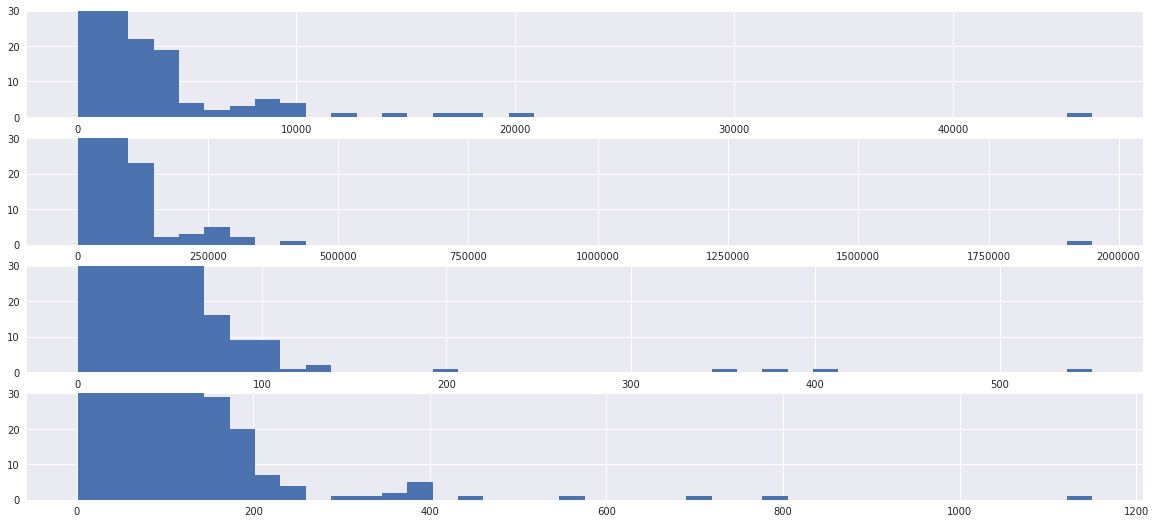

In [12]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(20,9)

cats = ["activity_comment_total","dollar_goal","reward_min","reward_mode_cost"]

for i, cat in enumerate(cats):
    ax[i].hist(df[cat],bins=40)
    ax[i].set_ylim([0,30])

#### Checking for nulls or zeros that shouldn't be possible

Scraper used -1 for nulls

In [13]:
print(len(df[df.backers_US < 0]), "projects with null US backers")
print(len(df[(df.backers_new < 0) | (df.backers_exist < 0)]), "projects with null new or existing backers")
print(len(df[df.reward_mode_backers == 0]), "projects with reward_mode_backers = 0")
print(len(df[df.reward_mode_cost < 0]), "projects with reward_mode_cost < 0")
print(len(df[(np.isnat(df.funding_start)) | (np.isnat(df.funding_end))]), "projects with null funding start or end")
print(len(df[df.funding_days <= 0]), "projects with <1 funding days")

# a few projects had a reward at $0 as an "early bird" promotion
print(len(df[df.reward_min == 0]), "projects with reward_min = 0 (ok)") 

2 projects with null US backers
0 projects with null new or existing backers
0 projects with reward_mode_backers = 0
0 projects with reward_mode_cost < 0
0 projects with null funding start or end
0 projects with <1 funding days
6 projects with reward_min = 0 (ok)


#### Remove additional outliers, null values, excess columns

In [14]:
#Input outliers
print(len(df[(df.activity_comment_total>=25000)
             &(df.dollar_goal>=400000) 
             & (df.reward_min>=300) 
             & (df.reward_mode_cost>=600)]), "additional outliers removed")
df = df[(df.activity_comment_total<25000) 
        & (df.dollar_goal<400000) 
        & (df.reward_min<300) 
        & (df.reward_mode_cost<600)]

#Nulls / zeros
print(len(df[df.backers_US == 0]),"additional null values removed")
df = df[df.backers_US >= 0]

#Remove extra columns
print(str(len(df.columns)-len(columns_target)-len(columns_data)),"columns removed")
df = df[columns_target + columns_data]

print (len(df), "samples in data frame\n")

df.head(5)

0 additional outliers removed
0 additional null values removed
12 columns removed
3847 samples in data frame



dollar_total  backers_total  backers_US  activity_comment_total  \
1          2727             44          39                       0   
3         24370            186         122                     126   
4          2894            134          90                      17   
5        117900           1010         605                     673   
6          4305             69          54                      21   

   activity_faq_end  activity_update_end  creator_backed  creator_projects  \
1                 0                    0              82                 1   
3                 0                   16               4                13   
4                 0                    4               0                 1   
5                 0                   18              34                27   
6                 0                    5               8                 1   

   dollar_goal  funding_days  reward_count  reward_min  reward_max  \
1         7000            28             7           5         500   
3        20000            30            13          40         720   
4         2500            30             7           1         500   
5        15000            27             6           1         239   
6         4000            30            11           1        1000   

   reward_median  reward_mode_cost  backers_US_pct  backers_new_pct  \
1           25.0                15        0.886364         0.545455   
3          170.0                70        0.655914         0.043011   
4           20.0                 3        0.671642         0.052239   
5           42.0                49        0.599010         0.035644   
6           49.0                58        0.782609         0.144928   

   funding_end_month  
1                  6  
3                 12  
4                 11  
5                  2  
6                 11

## 2) Exploratory Analysis

### Pair plots

#### Observations:
Data vs Targets:
- No obvious linear relationships
- A few plots (e.g. funding days, reward_mode_cost, backers_US_pct, backers_new_pct) seem to have an upside down parabola

Data vs. Data:
- No obvious linear relationships
- Many of the variables are heavily right skewed

#### Plots

['dollar_total', 'backers_total', 'backers_US']
['activity_comment_total', 'activity_faq_end', 'activity_update_end', 'creator_backed', 'creator_projects', 'dollar_goal', 'funding_days', 'reward_count', 'reward_min', 'reward_max', 'reward_median', 'reward_mode_cost', 'backers_US_pct', 'backers_new_pct', 'funding_end_month']


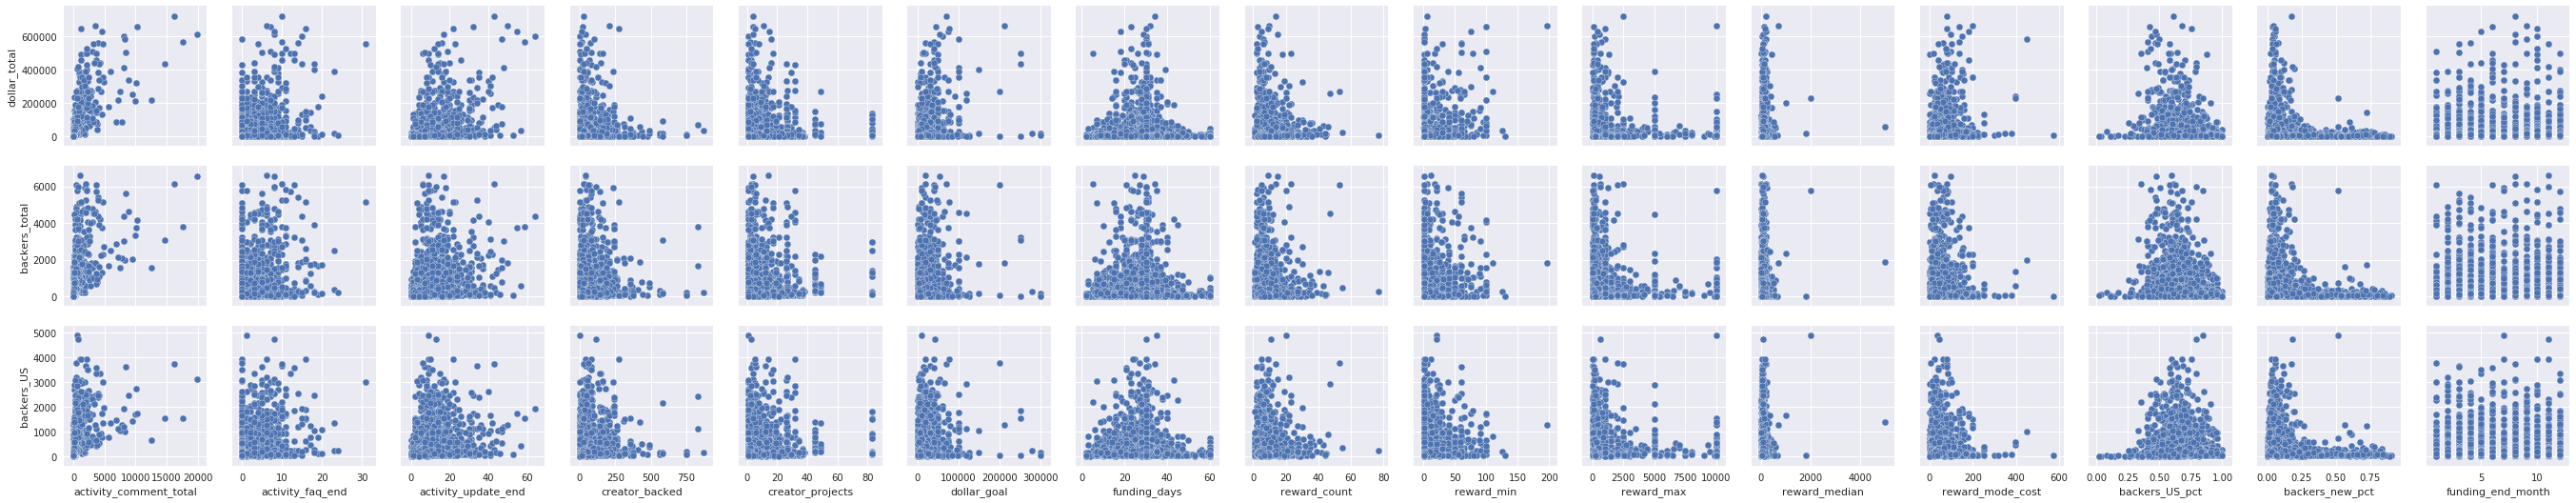

In [15]:
#Data vs Targets
sns.pairplot(df, x_vars = columns_data, y_vars = columns_target)
print(columns_target)
print(columns_data)

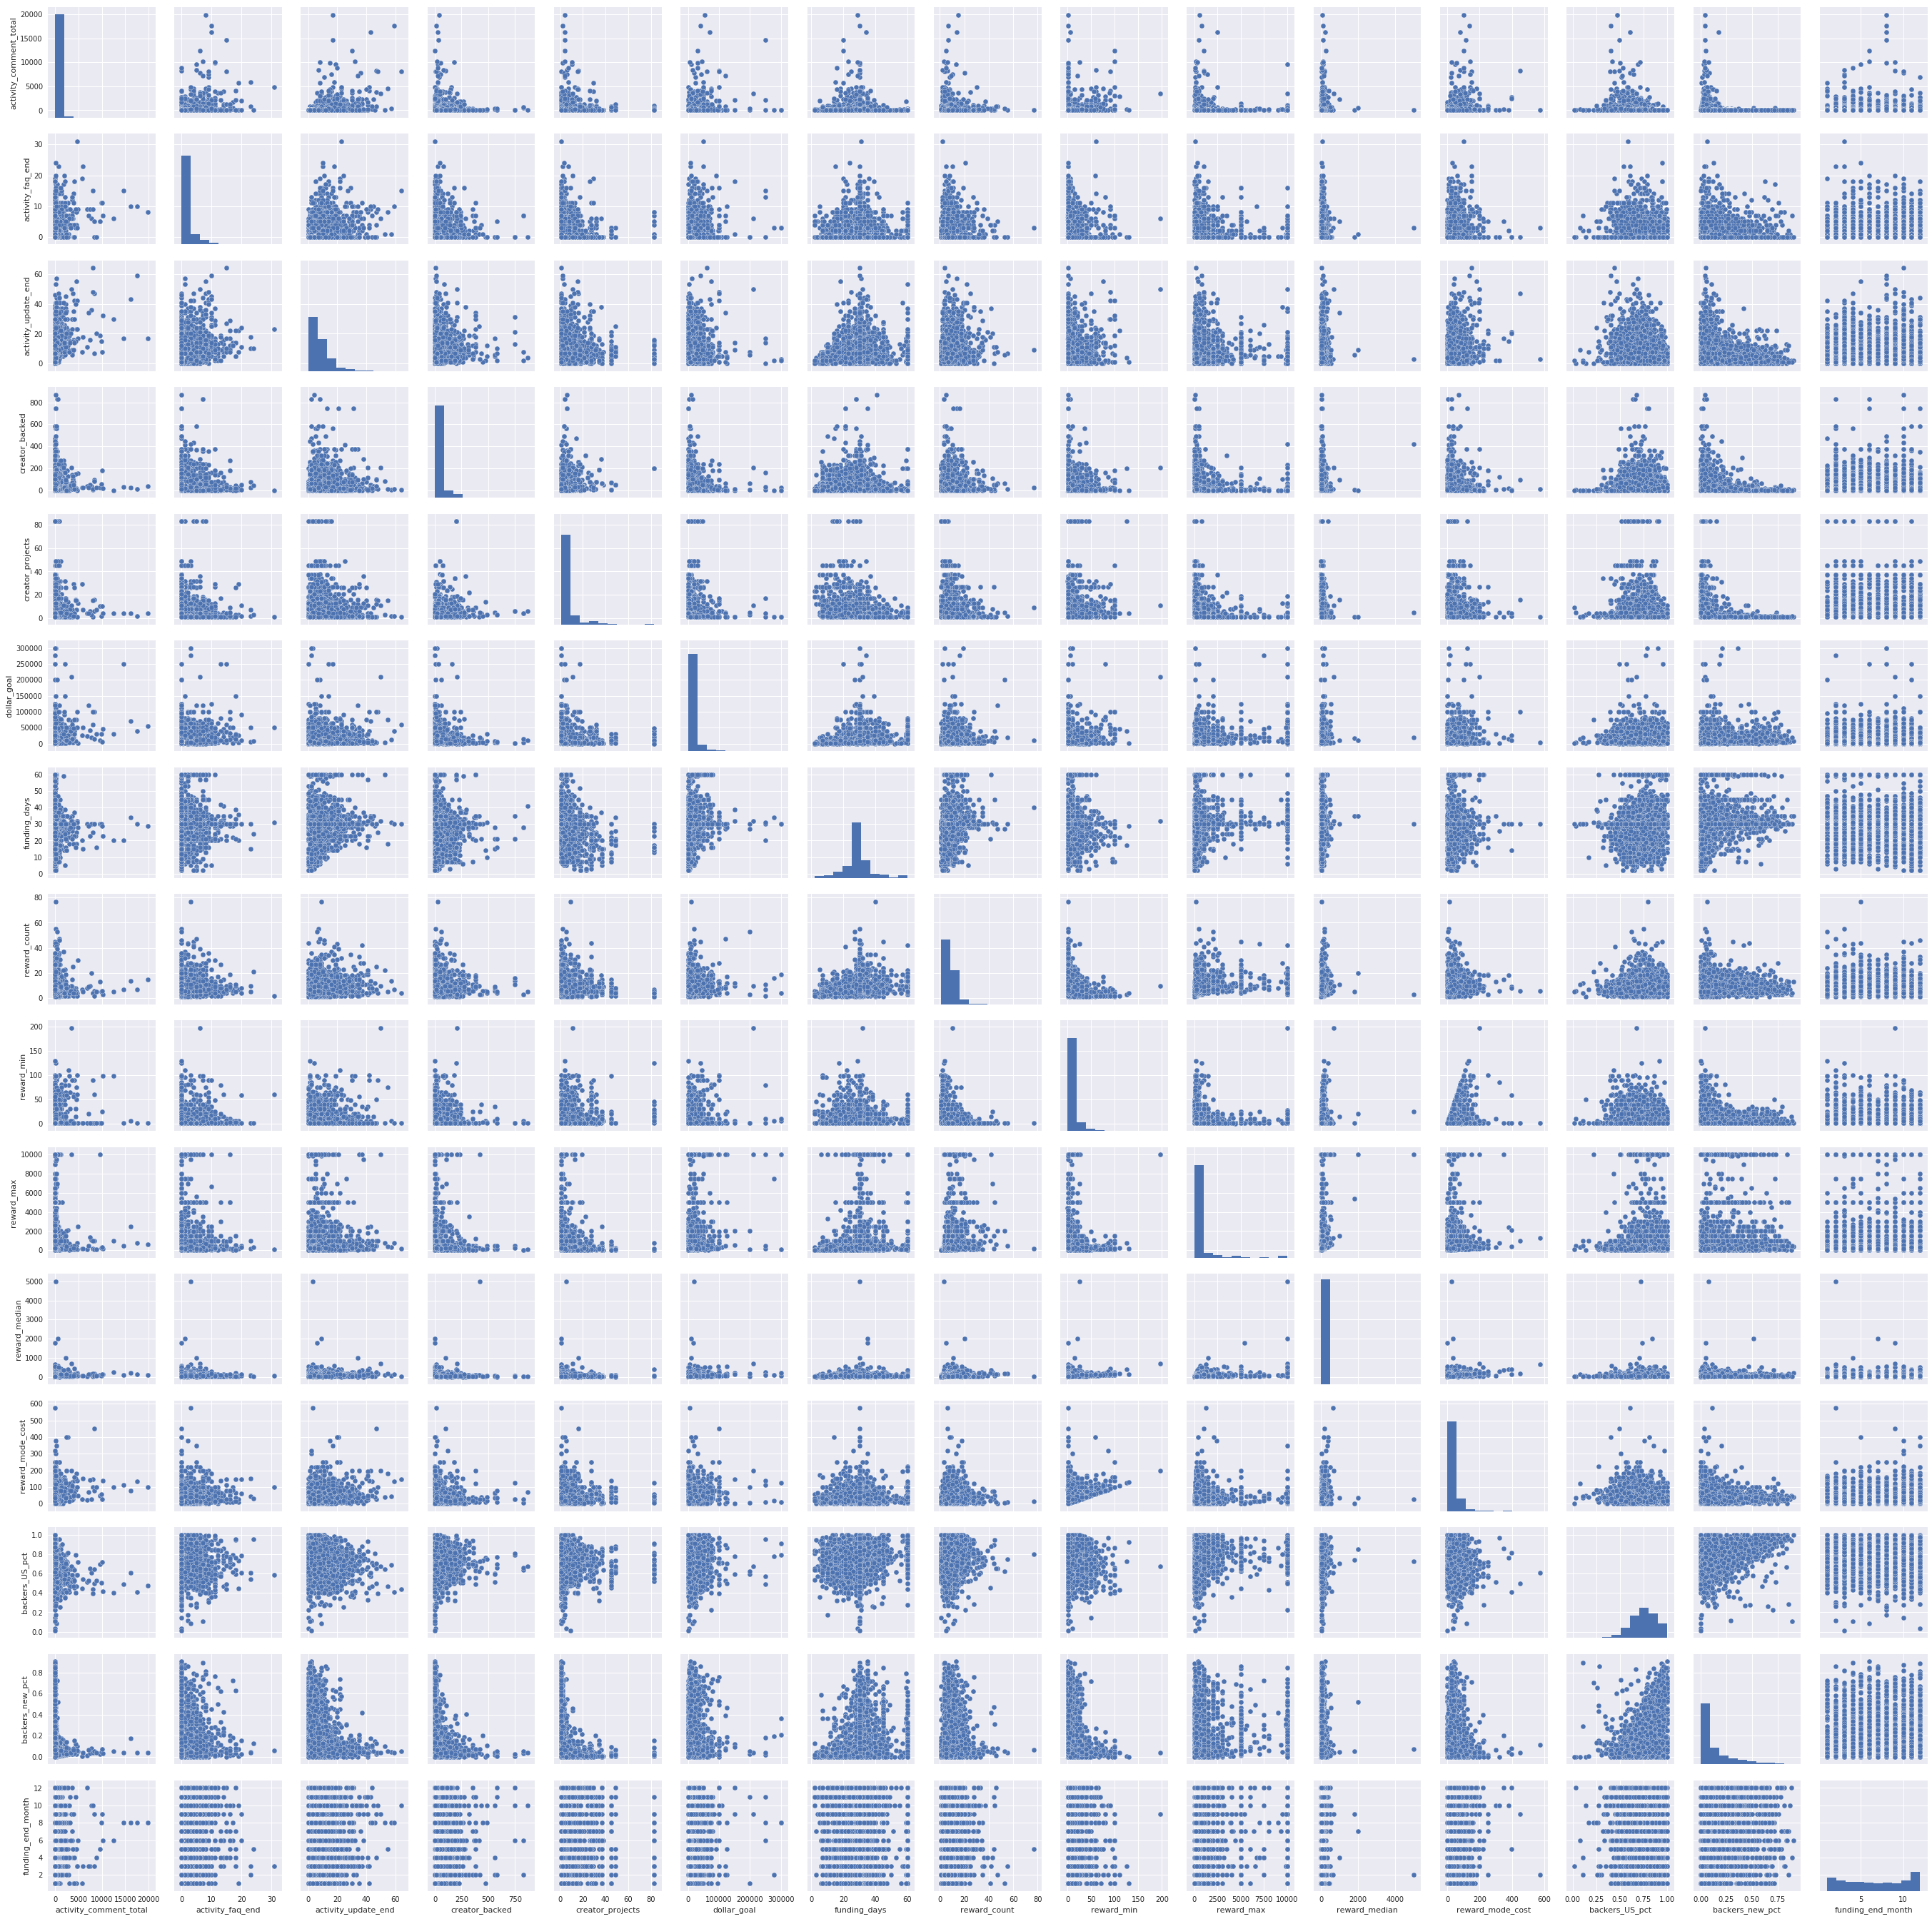

In [16]:
#Data vs Data
sns.pairplot(df, x_vars = columns_data, y_vars = columns_data)

### Correlations

#### Observations:
Target vs Data:
- Dollar target:
  - **0.0-0.1 correlation:** funding_days, reward_count, reward_max, funding_end_month
  - **0.1-0.2 correlation:** creator_backed, creator_projects, reward_median, backers_new_pct
- Backer targets:
  - **0.0-0.1 correlation:** reward_count, reward_max, reward_median, funding_end_month
  - **0.1-0.2 correlation:** creator_projects, funding_days, reward_min, reward_mode_cost, backers_new_pct
- Activity_comment_total has high correlation, but it includes comments after the project is over
  - FAQ and Update activity probably cover the same information as comments

Data vs Data:
- No correlations over 0.5
- Activity_comment_total, activity_faq_end, activity_update_end are more highly correlated (~0.2-3) than other inputs)

In [17]:
dollar_low_cor = ["reward_count","reward_max","funding_end_month","funding_days"]
dollar_less_cor = ["creator_backed","creator_projects","reward_median","backers_new_pct"]

backer_low_cor = ["reward_count","reward_max","funding_end_month","reward_median"]
backer_less_cor = ["creator_projects","funding_days","reward_min","reward_mode_cost","backers_new_pct"]

no_comments = ["activity_comment_total"]

mild = dollar_low_cor
medium = dollar_low_cor + dollar_less_cor
conservative = dollar_low_cor + dollar_less_cor + backer_less_cor

def filter_comments(data):
    filtered_cols = [x for x in data.columns if (x not in no_comments)]
    return data[filtered_cols]    
def filter_mild(data):
    filtered_cols = [x for x in data.columns if (x not in mild)]
    return data[filtered_cols]
def filter_medium(data):
    filtered_cols = [x for x in data.columns if (x not in medium)]
    return data[filtered_cols]
def filter_conservative(data):
    filtered_cols = [x for x in data.columns if (x not in conservative)]
    return data[filtered_cols]
    

#### Correlation matrices

In [18]:
# Target vs Data
df.corr()[["dollar_total","backers_total","backers_US"]]

dollar_total  backers_total  backers_US
dollar_total                1.000000       0.837363    0.795422
backers_total               0.837363       1.000000    0.978630
backers_US                  0.795422       0.978630    1.000000
activity_comment_total      0.716726       0.562869    0.501899
activity_faq_end            0.405822       0.367098    0.349608
activity_update_end         0.424281       0.346133    0.332391
creator_backed              0.104283       0.194760    0.207722
creator_projects            0.116775       0.167662    0.174394
dollar_goal                 0.364184       0.241752    0.227474
funding_days               -0.068821      -0.113112   -0.108917
reward_count                0.006427      -0.015752   -0.000659
reward_min                  0.269274       0.163623    0.138476
reward_max                  0.016984      -0.028375   -0.013884
reward_median               0.149168       0.099018    0.115773
reward_mode_cost            0.329617       0.126393    0.105709
backers_US_pct             -0.289057      -0.329695   -0.253996
backers_new_pct            -0.132903      -0.190471   -0.182700
funding_end_month          -0.007830      -0.024589   -0.027462

In [19]:
#Data vs data
df[columns_data].corr()

activity_comment_total  activity_faq_end  \
activity_comment_total                1.000000          0.320133   
activity_faq_end                      0.320133          1.000000   
activity_update_end                   0.377498          0.274272   
creator_backed                        0.058559          0.036016   
creator_projects                      0.058058         -0.044158   
dollar_goal                           0.271238          0.198129   
funding_days                         -0.054547          0.009526   
reward_count                         -0.008548          0.045160   
reward_min                            0.179198          0.056379   
reward_max                           -0.002882          0.017095   
reward_median                         0.083097          0.058526   
reward_mode_cost                      0.254681          0.142792   
backers_US_pct                       -0.250121         -0.144062   
backers_new_pct                      -0.115394         -0.043161   
funding_end_month                    -0.009503          0.003722   

                        activity_update_end  creator_backed  creator_projects  \
activity_comment_total             0.377498        0.058559          0.058058   
activity_faq_end                   0.274272        0.036016         -0.044158   
activity_update_end                1.000000        0.150738          0.033177   
creator_backed                     0.150738        1.000000          0.256503   
creator_projects                   0.033177        0.256503          1.000000   
dollar_goal                        0.122979       -0.042149         -0.048838   
funding_days                       0.053096       -0.146371         -0.335177   
reward_count                       0.163709       -0.009081         -0.071168   
reward_min                         0.074493       -0.003952          0.141749   
reward_max                         0.022702       -0.074831         -0.113337   
reward_median                      0.104597        0.038884         -0.027615   
reward_mode_cost                   0.236331       -0.008827          0.025150   
backers_US_pct                    -0.245786       -0.116001         -0.139201   
backers_new_pct                   -0.192775       -0.243554         -0.299917   
funding_end_month                  0.012514       -0.038403         -0.042408   

                        dollar_goal  funding_days  reward_count  reward_min  \
activity_comment_total     0.271238     -0.054547     -0.008548    0.179198   
activity_faq_end           0.198129      0.009526      0.045160    0.056379   
activity_update_end        0.122979      0.053096      0.163709    0.074493   
creator_backed            -0.042149     -0.146371     -0.009081   -0.003952   
creator_projects          -0.048838     -0.335177     -0.071168    0.141749   
dollar_goal                1.000000      0.123161      0.109102    0.157383   
funding_days               0.123161      1.000000      0.184200   -0.083083   
reward_count               0.109102      0.184200      1.000000   -0.209250   
reward_min                 0.157383     -0.083083     -0.209250    1.000000   
reward_max                 0.251758      0.130443      0.296332   -0.055420   
reward_median              0.176151      0.065156      0.147448    0.142609   
reward_mode_cost           0.263959      0.029029      0.023181    0.266138   
backers_US_pct            -0.060048      0.136244      0.081520   -0.114710   
backers_new_pct            0.105628      0.228492      0.047228   -0.084259   
funding_end_month          0.008899     -0.005704     -0.013407   -0.019654   

                        reward_max  reward_median  reward_mode_cost  \
activity_comment_total   -0.002882       0.083097          0.254681   
activity_faq_end          0.017095       0.058526          0.142792   
activity_update_end       0.022702       0.104597          0.236331   
creator_backed           -0.074831       0.038884         -0.008827   
creator_projects  

#### Heatmap

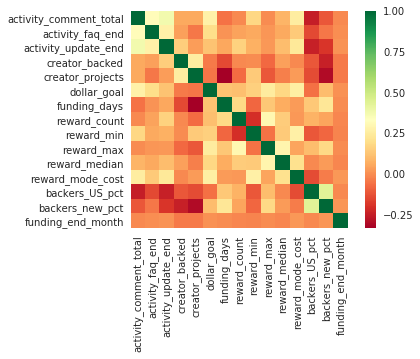

In [20]:
sns.heatmap(df[columns_data].corr(), square=True, cmap='RdYlGn')

### P-Values
How to think about pvalues of coefficients:
https://onlinecourses.science.psu.edu/stat501/node/297

#### Observations:
- Inputs to remove look similar to correlation analysis:
  - P values > .01: Reward count, reward_max, funding_end_month, funding_days, backers_new_pct

In [21]:
low_pvalue = ["reward_count","reward_max","funding_end_month","funding_days", "backers_new_pct"]

def filter_pvalue(data):
    filtered_cols = [x for x in data.columns if (x not in low_pvalue)]
    return data[filtered_cols]


#### StatsModels P-values

In [22]:
Y_pv = df[columns_target[0]]
X_pv = df[columns_data]

model = sm.OLS(Y_pv,X_pv)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           dollar_total   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     525.5
Date:                Tue, 17 Apr 2018   Prob (F-statistic):               0.00
Time:                        12:18:52   Log-Likelihood:                -46102.
No. Observations:                3847   AIC:                         9.223e+04
Df Residuals:                    3832   BIC:                         9.233e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
activity_comment_total    37.2631      0.821     45.408      0.000      35.654      38.872
activity_faq_end        3426.4704    237.702     14.415      0.000    2960.436    3892.505
activity_update_end     1113.2969    100.345     11.095      0.000     916.561    1310.032
creator_backed            30.3455      9.494      3.196      0.001      11.732      48.959
creator_projects         455.8866     77.192      5.906      0.000     304.546     607.227
dollar_goal                0.4738      0.037     12.921      0.000       0.402       0.546
funding_days            -132.5468     72.184     -1.836      0.066    -274.070       8.976
reward_count              32.3409    131.274      0.246      0.805    -225.033     289.715
reward_min               455.3142     50.589      9.000      0.000     356.130     554.498
reward_max                -0.6047      0.415     -1.457      0.145      -1.418       0.209
reward_median             21.6536      6.356      3.407      0.001       9.193      34.114
reward_mode_cost         126.1070     19.804      6.368      0.000      87.279     164.935
backers_US_pct         -1.873e+04   3375.824     -5.547      0.000   -2.53e+04   -1.21e+04
backers_new_pct         2988.6628   4299.117      0.695      0.487   -5440.114    1.14e+04
funding_end_month        102.1152    178.638      0.572      0.568    -248.119     452.349
==============================================================================
Omnibus:                     3115.919   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           210976.864
Skew:                           3.368   Prob(JB):                         0.00
Kurtosis:                      38.649   Cond. No.                     1.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
Y_pv = df[columns_target[0]]
X_pv = filter_pvalue(df[columns_data])

model = sm.OLS(Y_pv,X_pv)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           dollar_total   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     787.5
Date:                Tue, 17 Apr 2018   Prob (F-statistic):               0.00
Time:                        12:18:52   Log-Likelihood:                -46105.
No. Observations:                3847   AIC:                         9.223e+04
Df Residuals:                    3837   BIC:                         9.229e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
activity_comment_total    37.3617      0.819     45.630      0.000      35.756      38.967
activity_faq_end        3428.9748    237.510     14.437      0.000    2963.317    3894.633
activity_update_end     1073.1345     95.284     11.263      0.000     886.323    1259.946
creator_backed            30.4652      9.359      3.255      0.001      12.116      48.815
creator_projects         478.0479     73.316      6.520      0.000     334.305     621.790
dollar_goal                0.4573      0.035     12.984      0.000       0.388       0.526
reward_min               460.1923     49.146      9.364      0.000     363.838     556.547
reward_median             18.9001      6.092      3.103      0.002       6.957      30.843
reward_mode_cost         124.7962     19.696      6.336      0.000      86.181     163.412
backers_US_pct         -2.186e+04   1466.904    -14.900      0.000   -2.47e+04    -1.9e+04
==============================================================================
Omnibus:                     3125.837   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           212210.153
Skew:                           3.385   Prob(JB):                         0.00
Kurtosis:                      38.750   Cond. No.                     5.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3) Model selection

#### Helper method

In [24]:
seed = 42

X_all = df[columns_data]
Y_all = df[columns_target[0]]

X, X_holdout, Y, Y_holdout = train_test_split(X_all, Y_all, test_size = .2, random_state= seed, shuffle = True)

def do_data_science(model, X_in, Y_in, rand_state=42, folds = 5):
    '''
    Runs the model on the given data
    Input: 
        required: model, X (input), Y (target)
        optional: rand_state, folds (passes these through to kfolds)
    Output: prints model stats, shows diagnostic charts, returns fitted model
    '''
    kf = KFold(n_splits=5, shuffle=True, random_state = rand_state)

    model_rmse, model_mad, model_r2, model_train_r2 = [],[],[],[]
    
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15,3)
    ax[0].set_title("Predict vs. Observed")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Observed")
    
    ax[1].set_title("Predict vs. Residuals")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residuals")
    
    ax[2].set_title("Norm Dist vs. Residuals (Q-Q)")
    ax[2].set_xlabel("Norm Quantiles")
    ax[2].set_ylabel("Residual Quantiles")

    colors = ["b","g","r","c","m","y","k","w"]
    
    i = 0
    point_val = 0
    
    X_arg,Y_arg = np.array(X_in),np.array(Y_in)

    for train_ind, test_ind in kf.split(X_arg,Y_arg):
    
        X_train = X_arg[train_ind]
        X_test = X_arg[test_ind]
        Y_train = Y_arg[train_ind]
        Y_test = Y_arg[test_ind]

        model.fit(X_train,Y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        model_rmse.append(np.sqrt(np.mean((test_pred - Y_test)**2)))
        model_mad.append(np.mean(np.abs(test_pred - Y_test)))
        model_r2.append(model.score(X_test,Y_test))
        model_train_r2.append(model.score(X_train,Y_train))
        
        #Prediction vs actual
        point_val = max(point_val, min(np.max(Y_test),np.max(test_pred)))
        ax[0].scatter(test_pred,Y_test, alpha=.1, c=colors[i%len(colors)])

        #Residuals
        ax[1].scatter(test_pred, Y_test-test_pred, alpha=.1, c=colors[i%len(colors)])
        #plt.show()
        
        #Q-Q plot
        (x_norm, y_resid), (slope,intercept,_) = stats.probplot(Y_test-test_pred, dist="norm")
        ax[2].scatter(x_norm,y_resid,alpha=.1,c=colors[i%len(colors)])
        ax[2].plot(x_norm, slope*x_norm+intercept)
        
        i+=1
            
    ax[0].plot([0,point_val],[0,point_val],c="k")
    plt.show()

    #R-square
    print("Test R2:     ", np.mean(model_r2),"std dev:",np.std(model_r2))
    print("Train R2:    ", np.mean(model_train_r2),"std dev:",np.std(model_train_r2))
    
    #RMSE
    print("RMSE:        ",np.mean(model_rmse),"std dev:",np.std(model_rmse))
    
    # Mean Absolute Deviation
    print("Mean Abs Dev:",np.mean(model_mad),"std dev:",np.std(model_mad))

    #values
    #print("RMSE values:",model_rmse)
    #print("Mean Abs Dev values:",model_mad)
    print("Test R Square values:",model_r2)
    #print("Train R Square values:",model_train_r2)

    model.fit(X_arg, Y_arg)
    return model


### Ordinary linear regressions

#### Single variable

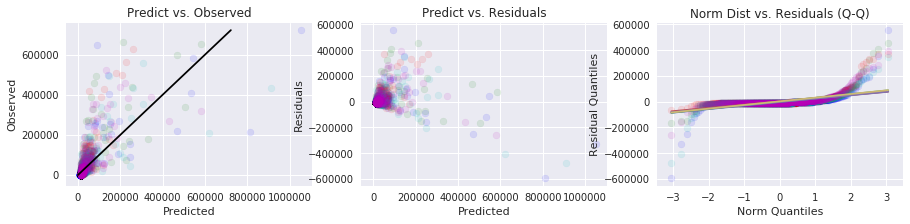

Test R2:      0.5111017610425236 std dev: 0.051124294744596024
Train R2:     0.539723952194352 std dev: 0.011359148742388732
RMSE:         43765.569104006914 std dev: 2307.5544968569316
Mean Abs Dev: 17822.142327087524 std dev: 569.4054732714999
Test R Square values: [0.46053295909035397, 0.585830260579588, 0.5149396137333468, 0.44956218938354114, 0.5446437824257879]


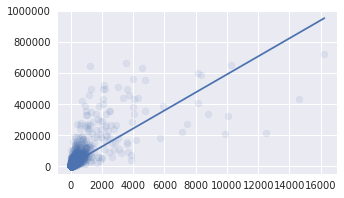

Slope: 57.9280566555435 Intercept 12302.555925017117


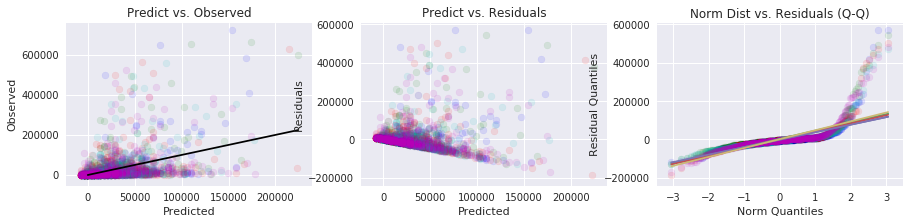

Test R2:      0.18081952438303844 std dev: 0.06349690664773208
Train R2:     0.1925086035954072 std dev: 0.016688917042380506
RMSE:         56724.88331729391 std dev: 2944.4277163275133
Mean Abs Dev: 25868.88950192363 std dev: 1357.253291167869
Test R Square values: [0.2589328409649355, 0.25105689827860556, 0.10670658181112791, 0.16462858614156695, 0.12277271471895622]


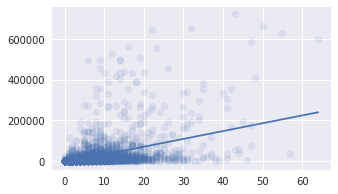

Slope: 3847.9884392235163 Intercept -5955.025352471348


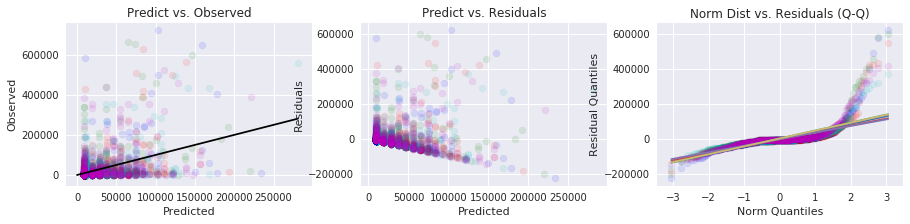

Test R2:      0.17767725531466821 std dev: 0.05495187603909639
Train R2:     0.1737582965473729 std dev: 0.011857570314215337
RMSE:         57066.748985655315 std dev: 5694.322736843555
Mean Abs Dev: 25981.780156296754 std dev: 1130.9878100688616
Test R Square values: [0.14651709843230887, 0.13352532465342393, 0.16656818047067634, 0.28538773900812686, 0.15638793400880513]


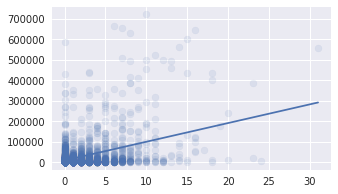

Slope: 9105.586432056693 Intercept 10015.596958631693


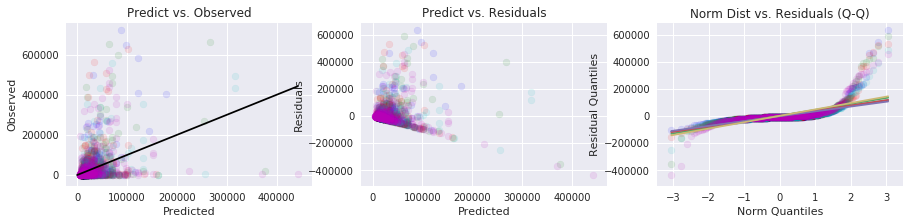

Test R2:      0.1388096013008513 std dev: 0.09604615471442939
Train R2:     0.15029874915553948 std dev: 0.021155859492961816
RMSE:         58248.686487330684 std dev: 5309.2690185476995
Mean Abs Dev: 25631.460647165037 std dev: 1582.7850374104562
Test R Square values: [0.20328094128042107, 0.17292265622557712, 0.07943002381279496, 0.25431755841471715, -0.01590317322925383]


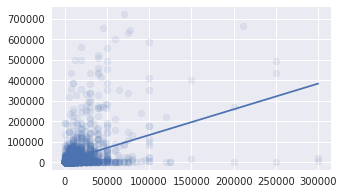

Slope: 1.253460599146362 Intercept 8242.306093334424


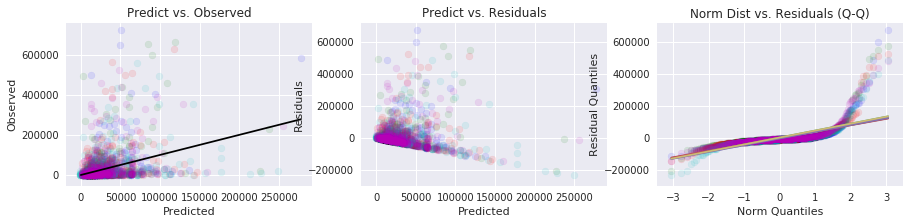

Test R2:      0.11359251224400564 std dev: 0.045643565366661476
Train R2:     0.1261403835668874 std dev: 0.010339660889060066
RMSE:         59040.23995436235 std dev: 2762.901233323694
Mean Abs Dev: 26454.853801900004 std dev: 481.69260621705524
Test R Square values: [0.15302025441365008, 0.16641267176161645, 0.08734809856152637, 0.04055853292489897, 0.12062300355833633]


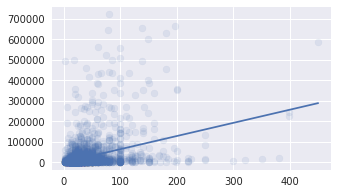

Slope: 640.5731791976812 Intercept 933.0627986219806


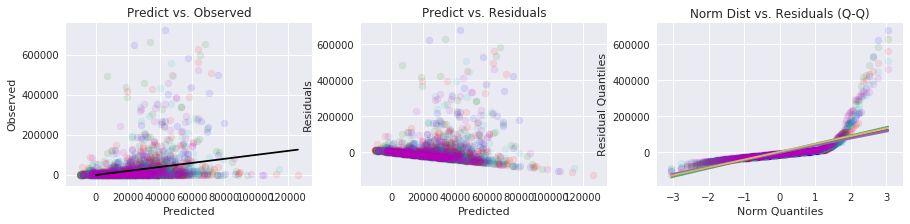

Test R2:      0.07905767582133157 std dev: 0.0153648292880097
Train R2:     0.08049455225841129 std dev: 0.0042064659847268334
RMSE:         60312.98649956612 std dev: 4466.302706519307
Mean Abs Dev: 27827.622395090573 std dev: 928.8604262948325
Test R Square values: [0.0829620826962334, 0.06189381092780466, 0.06380507262594792, 0.08255646415745489, 0.10407094869921696]


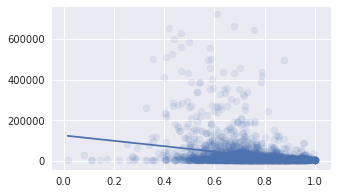

Slope: -133111.9120537885 Intercept 124108.3913220375


In [25]:
def single_var_xy_chart(mod,X_in,Y_in):
    
    plt.figure(figsize=(5,3))
    plt.scatter(X_in,Y_in,alpha =.1)
    
    x0 = np.min(X_in) 
    xn = np.max(X_in)
    slope, intercept = mod.coef_[0], mod.intercept_
    plt.plot([x0,xn],[slope*x0+intercept,slope*xn+intercept])
    plt.show()
    
#Single vars with highest correlation to target

lin_mod = do_data_science(LinearRegression(), X[["activity_comment_total"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["activity_comment_total"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)


lin_mod = do_data_science(LinearRegression(), X[["activity_update_end"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["activity_update_end"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)

lin_mod = do_data_science(LinearRegression(), X[["activity_faq_end"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["activity_faq_end"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)

lin_mod = do_data_science(LinearRegression(), X[["dollar_goal"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["dollar_goal"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)

lin_mod = do_data_science(LinearRegression(), X[["reward_mode_cost"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["reward_mode_cost"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)


lin_mod = do_data_science(LinearRegression(), X[["backers_US_pct"]], Y, rand_state=seed)
single_var_xy_chart(lin_mod,X["backers_US_pct"], Y)
print("Slope:",lin_mod.coef_[0], "Intercept", lin_mod.intercept_)


#### 4 variables

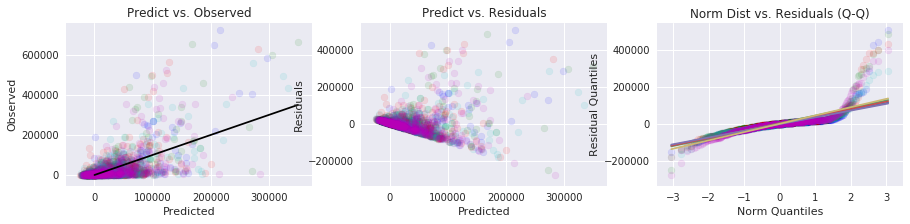

Test R2:      0.37921953709824285 std dev: 0.08071914344937345
Train R2:     0.3922188872975097 std dev: 0.019015763687018426
RMSE:         49385.115757195075 std dev: 4328.713121351597
Mean Abs Dev: 25378.79752872223 std dev: 1511.6434423313692
Test R Square values: [0.4470228216824799, 0.4246502496842403, 0.287242978764198, 0.4614106402225525, 0.2757709951377433]


(array([2.55889032e+03, 5.69712583e+03, 8.03140197e-01, 3.01432384e+02]),
 -26086.70998750254)

In [26]:
#Highest target correlation
lin_mod = do_data_science(LinearRegression(), X[["activity_update_end","activity_faq_end","dollar_goal","reward_mode_cost"]], Y, rand_state=seed)
lin_mod.coef_,lin_mod.intercept_

#### Remove features w/ low correlation

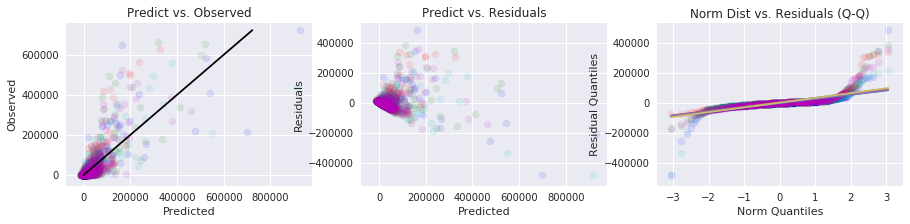

Test R2:      0.5844100638283892 std dev: 0.035607950460115334
Train R2:     0.6142275151694176 std dev: 0.008471981283452884
RMSE:         40355.40192648995 std dev: 1408.0906685627074
Mean Abs Dev: 17563.30122015457 std dev: 1014.5870038920945
Test R Square values: [0.5796584737507084, 0.6485340431486779, 0.5566564652597297, 0.5469785484246498, 0.5902227885581806]


[('activity_comment_total', 44.20552318640373),
 ('activity_faq_end', 3116.689864425037),
 ('activity_update_end', 1211.7293686868072),
 ('dollar_goal', 0.5111532391247238),
 ('backers_US_pct', -34715.59465292166)]

In [27]:
#Strictest filter
X_sub = filter_conservative(X)
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

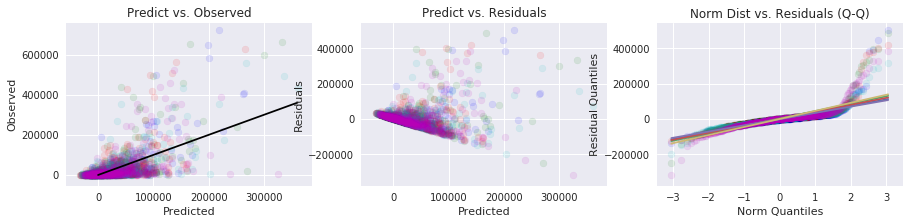

Test R2:      0.38112614540796097 std dev: 0.08337357108921986
Train R2:     0.3918096426316848 std dev: 0.018797458785999935
RMSE:         49346.121803026304 std dev: 4879.125943936506
Mean Abs Dev: 25927.36990246667 std dev: 1977.6952849994113
Test R Square values: [0.4490638561771609, 0.40098395061701925, 0.3024967368936142, 0.48498963187491984, 0.26809655147709055]


[('activity_faq_end', 5602.449480107109),
 ('activity_update_end', 2566.4146641606862),
 ('dollar_goal', 0.9299570616408346),
 ('backers_US_pct', -74658.46702612058)]

In [28]:
#Strictest filter, remove comments_total
X_sub = filter_comments(filter_conservative(X))
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

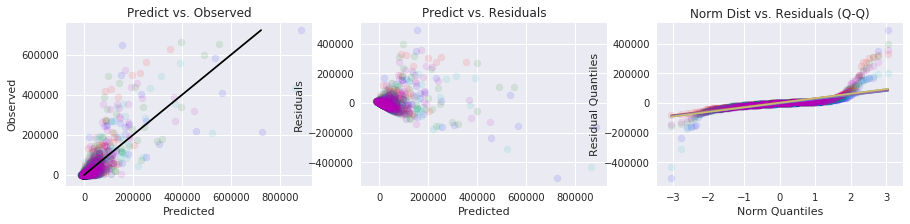

Test R2:      0.6015857892019542 std dev: 0.03535623481668835
Train R2:     0.6298592812574193 std dev: 0.008685418927814435
RMSE:         39524.74568042821 std dev: 1856.066978917249
Mean Abs Dev: 17359.024920476117 std dev: 795.90868134425
Test R Square values: [0.5755231015739497, 0.6682858961179334, 0.5773738298269722, 0.5792126936143454, 0.6075334248765702]


[('activity_comment_total', 42.09748785299962),
 ('activity_faq_end', 3136.7933189846012),
 ('activity_update_end', 1105.6789751616475),
 ('dollar_goal', 0.41774940830509877),
 ('reward_min', 457.0905825344364),
 ('reward_mode_cost', 128.35466622670046),
 ('backers_US_pct', -29373.1172944593)]

In [29]:
#Medium filter
X_sub = filter_medium(X)
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

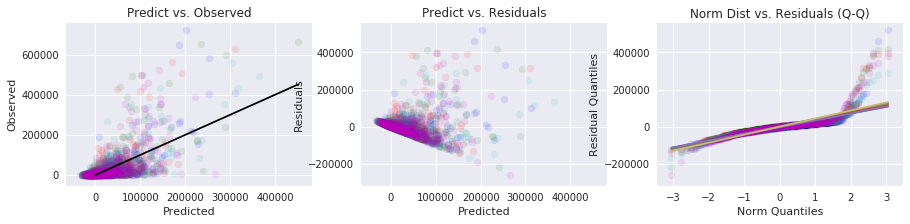

Test R2:      0.42037026696343033 std dev: 0.06156788449668458
Train R2:     0.4344160602220189 std dev: 0.01466961812811481
RMSE:         47754.22760588971 std dev: 3844.678240712542
Mean Abs Dev: 25295.566715430374 std dev: 1512.5624454620006
Test R Square values: [0.4717953881742432, 0.45826409989121686, 0.35939023395556813, 0.47952346555064795, 0.3328781472454757]


[('activity_faq_end', 5439.427494637557),
 ('activity_update_end', 2282.4524063087606),
 ('dollar_goal', 0.7442644157154064),
 ('reward_min', 723.0263446444362),
 ('reward_mode_cost', 217.41046949120886),
 ('backers_US_pct', -62920.35406417638)]

In [30]:
#Medium filter, remove comments_total
X_sub = filter_comments(filter_medium(X))
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

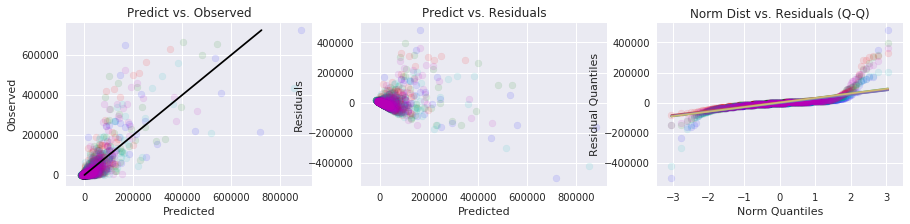

Test R2:      0.6071285985653219 std dev: 0.03391102781655638
Train R2:     0.6364045984430053 std dev: 0.008510840938219615
RMSE:         39250.47377605091 std dev: 1777.5708521876281
Mean Abs Dev: 17347.047835946392 std dev: 681.086783788141
Test R Square values: [0.5845602987995422, 0.6713313353353586, 0.5843354635089484, 0.5831916612282664, 0.612224233954494]


[('activity_comment_total', 41.848284619084744),
 ('activity_faq_end', 3240.334075697602),
 ('activity_update_end', 1022.1087103260444),
 ('creator_backed', 33.74553257175408),
 ('creator_projects', 411.4601702902307),
 ('dollar_goal', 0.41023741522531054),
 ('reward_min', 395.8799989519509),
 ('reward_median', 39.83184478157269),
 ('reward_mode_cost', 114.16763581627406),
 ('backers_US_pct', -27422.44624199275),
 ('backers_new_pct', 2494.8302833114954)]

In [31]:
#Weakest filter
X_sub = filter_mild(X)
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

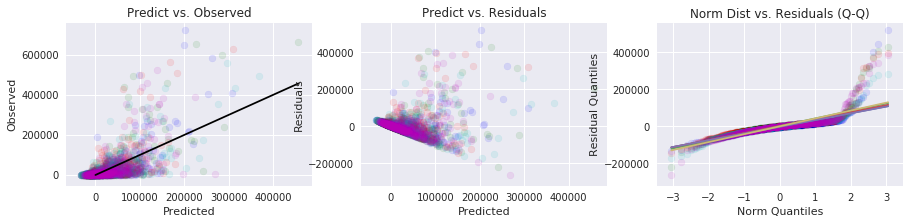

Test R2:      0.4261252251775206 std dev: 0.05595499058601585
Train R2:     0.4440456157581304 std dev: 0.013591792287330326
RMSE:         47521.48391662781 std dev: 3648.8212060661886
Mean Abs Dev: 25121.91010723316 std dev: 1279.7602322462324
Test R Square values: [0.4770924903971966, 0.4619663254908361, 0.37177456843882206, 0.47428508463516483, 0.34550765692558316]


[('activity_faq_end', 5557.404142711482),
 ('activity_update_end', 2198.6593450949144),
 ('creator_backed', 34.65753802811851),
 ('creator_projects', 551.2287340259969),
 ('dollar_goal', 0.7474775423656865),
 ('reward_min', 651.487418128087),
 ('reward_median', 28.88240842013311),
 ('reward_mode_cost', 208.13737504646988),
 ('backers_US_pct', -58608.713466141475),
 ('backers_new_pct', 1550.5023065490282)]

In [32]:
#Weakest filter, remove comments_total
X_sub = filter_comments(filter_mild(X))
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

#### All vars

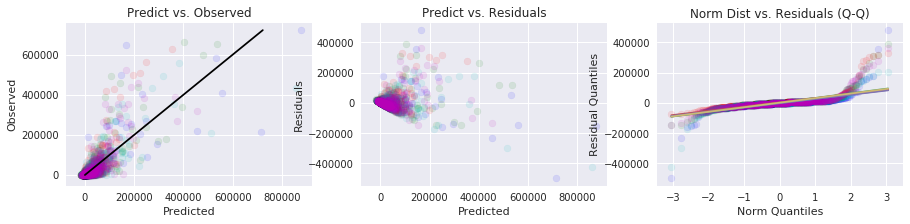

Test R2:      0.6079553885529845 std dev: 0.03346094401924389
Train R2:     0.6376922981288426 std dev: 0.008293754254121799
RMSE:         39211.07537521435 std dev: 1774.7517811626872
Mean Abs Dev: 17434.420966965343 std dev: 713.6287372810937
Test R Square values: [0.5854191366623487, 0.6708171773277922, 0.5858682015101471, 0.5832714424789176, 0.6144009847857167]


[('activity_comment_total', 41.432901384914224),
 ('activity_faq_end', 3222.7785492135827),
 ('activity_update_end', 1071.013375095785),
 ('creator_backed', 32.0104025092088),
 ('creator_projects', 350.4541616329641),
 ('dollar_goal', 0.43377354607673624),
 ('funding_days', -223.23215442586275),
 ('reward_count', -134.25815040441057),
 ('reward_min', 365.59967888962365),
 ('reward_max', -0.624884013692963),
 ('reward_median', 51.823545590864796),
 ('reward_mode_cost', 112.42044001979355),
 ('backers_US_pct', -26184.27561592613),
 ('backers_new_pct', 4327.383727006377),
 ('funding_end_month', -55.003078882599084)]

In [33]:
#All vars
X_sub = X
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

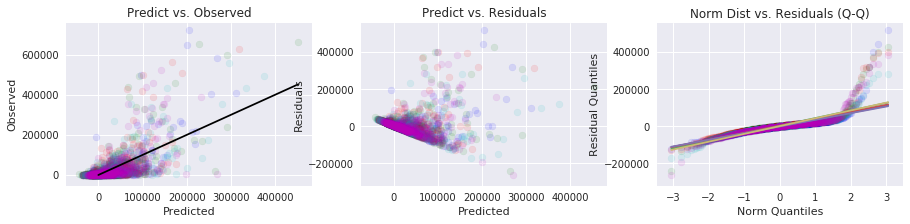

Test R2:      0.43407577255102714 std dev: 0.05344024922642407
Train R2:     0.4521644160708747 std dev: 0.012760385022391352
RMSE:         47203.13015844737 std dev: 3687.4866020315326
Mean Abs Dev: 25069.33870720035 std dev: 1224.662464723236
Test R Square values: [0.48097120014606076, 0.4647035377377314, 0.3796971545408744, 0.4854208527591103, 0.3595861175713586]


[('activity_faq_end', 5454.674394062175),
 ('activity_update_end', 2296.9294801493716),
 ('creator_backed', 30.221896286907594),
 ('creator_projects', 403.8374537318822),
 ('dollar_goal', 0.798932692853441),
 ('funding_days', -512.4097583810676),
 ('reward_count', -449.41694269710126),
 ('reward_min', 557.1327909222264),
 ('reward_max', -1.6332377568037373),
 ('reward_median', 62.902543348059226),
 ('reward_mode_cost', 200.614884906523),
 ('backers_US_pct', -54594.51721818109),
 ('backers_new_pct', 5931.916118823053),
 ('funding_end_month', -303.0131956050285)]

In [34]:
#All vars except comments_total
X_sub = filter_comments(X)
lin_mod = do_data_science(LinearRegression(), X_sub, Y, rand_state=seed)
list(zip (X_sub.columns, lin_mod.coef_))

### Linear Regression - Polynomial terms

#### 2nd degree - all polynomial terms

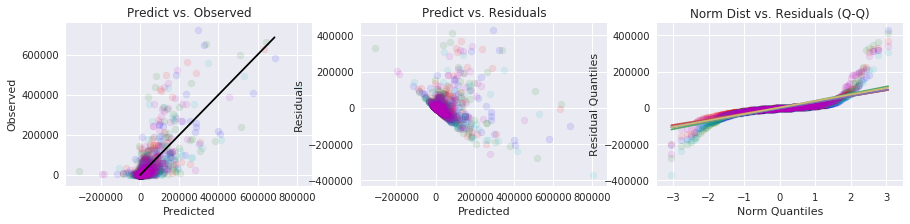

Test R2:      0.507203901409912 std dev: 0.04673766973040756
Train R2:     0.6602195796620337 std dev: 0.00925096696566277
RMSE:         44011.30950320365 std dev: 3210.1390640689315
Mean Abs Dev: 20682.820928590023 std dev: 1164.9465309391626
Test R Square values: [0.5858952353149174, 0.48793948893944633, 0.5283722679769034, 0.44870316327075044, 0.48510935154754276]


In [35]:
#All poly terms, all Inputs
poly_all = PolynomialFeatures(degree=2)

X2_poly_all = poly_all.fit_transform(filter_comments(X))

lin_mod = do_data_science(LinearRegression(), X2_poly_all, Y, rand_state=seed)

#### 2nd degree - interaction terms only 

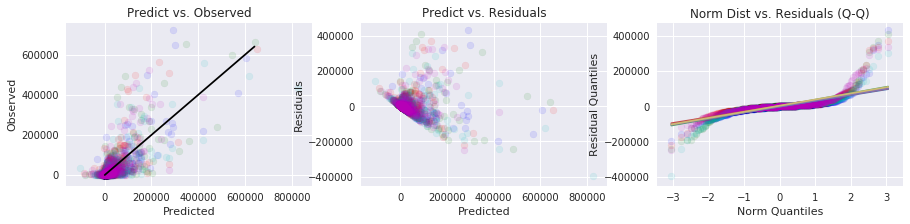

Test R2:      0.5258475442971913 std dev: 0.050422735007595094
Train R2:     0.6517410774976093 std dev: 0.009233698747863096
RMSE:         43084.737745028426 std dev: 2029.184207445577
Mean Abs Dev: 19933.286344420492 std dev: 612.1016116993554
Test R Square values: [0.6032639124416183, 0.5530362041473731, 0.5144187239570812, 0.4517983500299686, 0.506720530909915]


In [36]:
#Interaction terms, all vars
poly_interaction = PolynomialFeatures(degree=2, interaction_only=True)

X2_interact = poly_interaction.fit_transform(filter_comments(X))

lin_mod = do_data_science(LinearRegression(), X2_interact, Y, rand_state=seed)


#### 2nd degree - square terms only

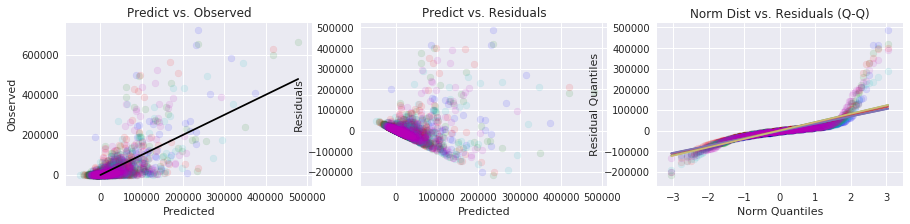

Test R2:      0.4532415397540873 std dev: 0.05328547212357891
Train R2:     0.49216661905200454 std dev: 0.014211819378871376
RMSE:         46352.71898357052 std dev: 3150.3031865459893
Mean Abs Dev: 23951.289622488282 std dev: 1090.441824590085
Test R Square values: [0.5116530899577116, 0.49494454784452885, 0.38385337092302907, 0.48123087746151916, 0.39452581258364805]


In [37]:
# poly square terms, all vars
def poly_squares(df_orig):
    '''
    Input: data frame
    Output: data frame with square of each column added
    '''
    data = df_orig.copy()
    for c in data.columns:
        data[c+"_square"] = data[c]**2
        
    return data


X_squares = poly_squares(filter_comments(X))

lin_mod = do_data_science(LinearRegression(), X_squares, Y, rand_state=seed)

#### 3nd degree - interaction terms only 

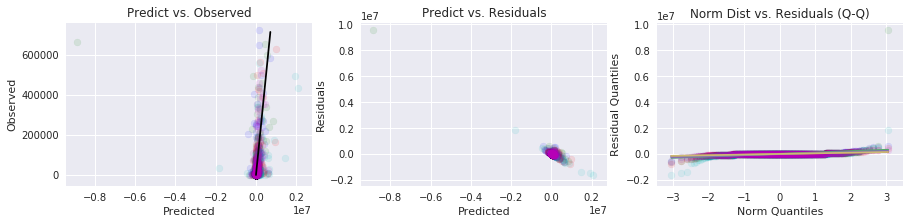

Test R2:      -7.4061403871114235 std dev: 11.762042607940618
Train R2:     0.8240875848572642 std dev: 0.010902273964270228
RMSE:         148742.49005713846 std dev: 125430.24052097807
Mean Abs Dev: 35762.54152703062 std dev: 7438.690124249187
Test R Square values: [-0.31626852526645743, -30.483046115470653, -0.2438231541584155, -6.050068261552971, 0.06250412089138024]


In [38]:
#Interaction terms, all vars
poly_interaction = PolynomialFeatures(degree=3, interaction_only=True)

X3_interact = poly_interaction.fit_transform(filter_comments(X))

lin_mod = do_data_science(LinearRegression(), X3_interact, Y, rand_state=seed)


#### 3rd degree - square terms only

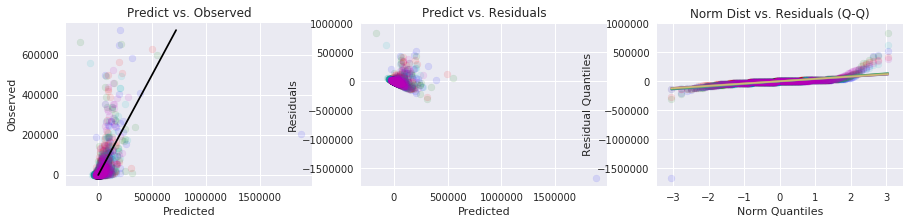

Test R2:      0.13554675114591325 std dev: 0.38612023385718947
Train R2:     0.4777410842524974 std dev: 0.0184701821993193
RMSE:         57534.10766919322 std dev: 13830.335198196539
Mean Abs Dev: 26148.197281066616 std dev: 1136.6763887421998
Test R Square values: [-0.625997731859153, 0.2217650159203779, 0.39035408259382287, 0.29724827570109896, 0.39436411337341937]


In [39]:
# poly cubes terms, all vars
def poly_cubes(df_orig):
    '''
    Input: data frame
    Output: data frame with square of each column added
    '''
    data = df_orig.copy()
    for c in data.columns:
        data[c+"_square"] = data[c]**2
        data[c+"_cube"] = data[c]**3
        
    return data


X_cubes = poly_cubes(filter_comments(X))

lin_mod = do_data_science(LinearRegression(), X_cubes, Y, rand_state=seed)

### Lasso regression

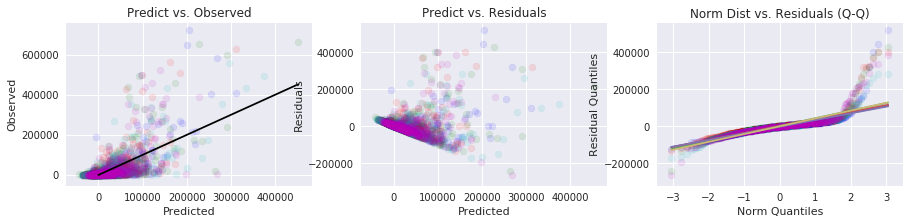

Test R2:      0.43337869418790503 std dev: 0.054306921330728036
Train R2:     0.45199453726851885 std dev: 0.012568366479307449
RMSE:         47230.14866145035 std dev: 3701.383376804733
Mean Abs Dev: 24965.086654666313 std dev: 1220.5322113394827
Test R Square values: [0.4809712164535201, 0.46470355543999725, 0.3782987897956922, 0.48542089911732045, 0.3574990101329951]


In [40]:
alphalist = 10**np.linspace(-2,5,200)

#Scaler + lasso CV pipeline
steps = [('standardize', StandardScaler()), ('lasso', LassoCV(alphas = alphalist, random_state=seed))]

lasso_mod = do_data_science(Pipeline(steps), filter_comments(X), Y, rand_state=seed)


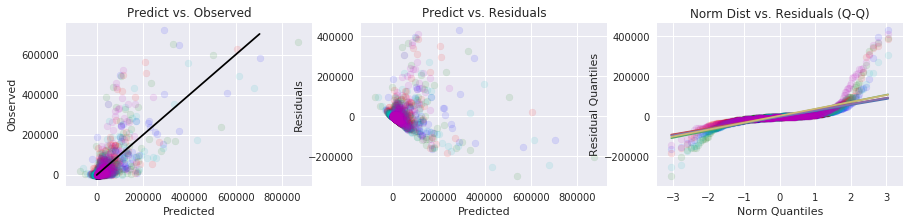

Test R2:      0.5283752937130176 std dev: 0.0720978277455532
Train R2:     0.6196134079063156 std dev: 0.03185990903361768
RMSE:         42988.53283013981 std dev: 4135.787072402726
Mean Abs Dev: 18881.20072133734 std dev: 1070.5100635420529
Test R Square values: [0.639256439840334, 0.5325337050585787, 0.5213531023405241, 0.5367980771497143, 0.4119351441759369]


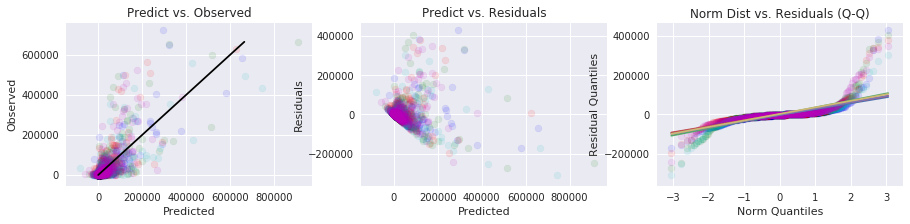

Test R2:      0.5414010655758134 std dev: 0.04622576201527191
Train R2:     0.6363284235730889 std dev: 0.013939769706941729
RMSE:         42436.75972277429 std dev: 3067.787056611588
Mean Abs Dev: 18629.368904398958 std dev: 719.4220975337595
Test R Square values: [0.6315292189216535, 0.5315844887037563, 0.528853990596386, 0.5051509845435624, 0.5098866451137078]


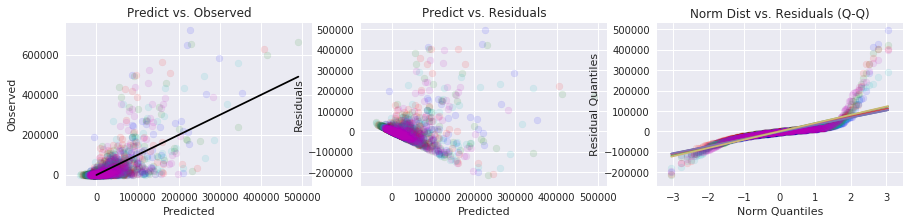

Test R2:      0.4469973490680255 std dev: 0.05941866348582891
Train R2:     0.4873693259206731 std dev: 0.013646366723810715
RMSE:         46606.20970130527 std dev: 3331.7322577825994
Mean Abs Dev: 23322.0186314138 std dev: 1122.3377828103437
Test R Square values: [0.5063900172291009, 0.4952742438533546, 0.3764636253239596, 0.4837927692729515, 0.37306608966076094]


In [41]:
alphalist = 10**np.linspace(0,5,200)

#make scaling + regression pipeline
steps = [('standardize', StandardScaler()), ('lasso', LassoCV(alphas = alphalist, random_state=seed, max_iter=5000))]

lasso_mod = do_data_science(Pipeline(steps), X2_poly_all, Y, rand_state=seed)

lasso_mod = do_data_science(Pipeline(steps), X2_interact, Y, rand_state=seed)

lasso_mod = do_data_science(Pipeline(steps), X_squares, Y, rand_state=seed)

## 4) Model Testing

### Predictive model - Regression w/ interaction terms

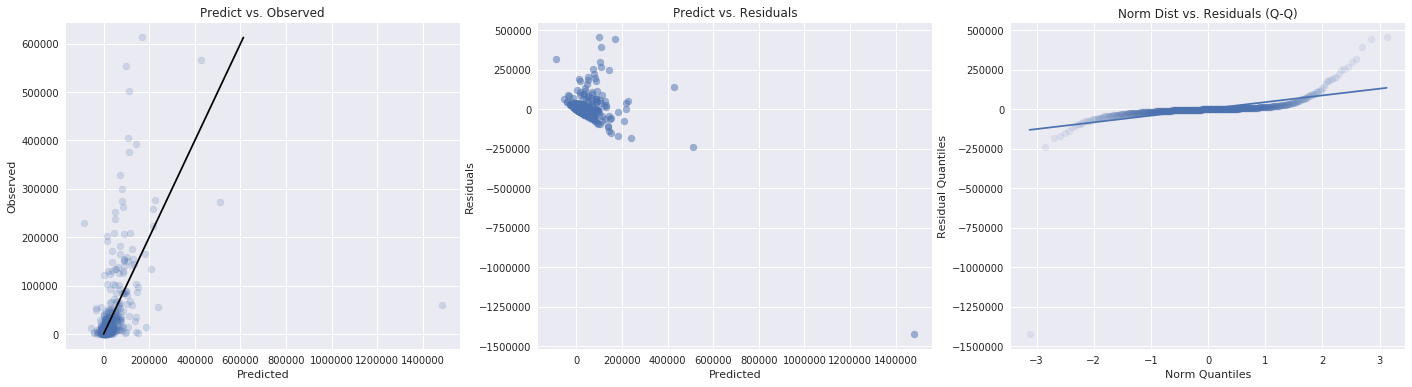

RMSE 71162.50702445747
MAD 22964.576057019647
R2 -0.2651190750640966
Train R2 0.6420656425532867
Index(['activity_faq_end', 'activity_update_end', 'creator_backed',
       'creator_projects', 'dollar_goal', 'funding_days', 'reward_count',
       'reward_min', 'reward_max', 'reward_median', 'reward_mode_cost',
       'backers_US_pct', 'backers_new_pct', 'funding_end_month'],
      dtype='object')


[('1', -1.4206003545915173e-05),
 ('x0', 15682.747320262662),
 ('x1', 3811.501028801854),
 ('x2', -66.99836051592652),
 ('x3', -1011.1703607491199),
 ('x4', 1.3874284464369668),
 ('x5', -1275.9815649768764),
 ('x6', 3075.267465557693),
 ('x7', 3188.678895431444),
 ('x8', 5.385616506906452),
 ('x9', -697.9838832210131),
 ('x10', 565.7286662386335),
 ('x11', -35268.210966746774),
 ('x12', -54072.86261167993),
 ('x13', -1106.2146619129385),
 ('x0 x1', 40.818217591849084),
 ('x0 x2', 21.327519680712673),
 ('x0 x3', -45.996543053316366),
 ('x0 x4', 0.011631792517619033),
 ('x0 x5', -122.96440230696446),
 ('x0 x6', 23.8703288429501),
 ('x0 x7', 73.27576406737629),
 ('x0 x8', -0.02783350172808774),
 ('x0 x9', 22.46024813435148),
 ('x0 x10', 17.921233598865534),
 ('x0 x11', -17855.947339998864),
 ('x0 x12', -752.3017058653907),
 ('x0 x13', 155.7592456012465),
 ('x1 x2', -1.751161657463193),
 ('x1 x3', 51.058069362328816),
 ('x1 x4', 0.049829617472823884),
 ('x1 x5', -37.318035599181414),
 ('x1

In [42]:
#Interaction terms, all vars
poly_interaction = PolynomialFeatures(degree=2, interaction_only=True)

X2_interact = poly_interaction.fit_transform(filter_comments(X))
X_holdout_interact = poly_interaction.fit_transform(filter_comments(X_holdout))

X_interact_labels = poly_interaction.get_feature_names()

X_train, Y_train = np.array(X2_interact),np.array(Y)
X_test, Y_test = np.array(X_holdout_interact),np.array(Y_holdout)

#X_train, Y_train = np.array(filter_comments(X)),np.array(Y)
#X_test, Y_test = np.array(filter_comments(X_holdout)),np.array(Y_holdout)

model = LinearRegression()

#alphalist = 10**np.linspace(0,5,200)
#steps = [('standardize', StandardScaler()), ('lasso', LassoCV(alphas = alphalist, random_state=seed, max_iter=5000))]
#model = Pipeline(steps)

model.fit(X_train,Y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

model_rmse = (np.sqrt(np.mean((test_pred - Y_test)**2)))
model_mad = (np.mean(np.abs(test_pred - Y_test)))
model_r2 = (model.score(X_test,Y_test))
model_train_r2 = (model.score(X_train,Y_train))


fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,6)
ax[0].set_title("Predict vs. Observed")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Observed")

ax[1].set_title("Predict vs. Residuals")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residuals")

ax[2].set_title("Norm Dist vs. Residuals (Q-Q)")
ax[2].set_xlabel("Norm Quantiles")
ax[2].set_ylabel("Residual Quantiles")


#Prediction vs actual
point_val = min(np.max(Y_test),np.max(test_pred))
ax[0].scatter(test_pred,Y_test, alpha=.2)

#Residuals
ax[1].scatter(test_pred, Y_test-test_pred, alpha=.5)
#plt.show()

#Q-Q plot
(x_norm, y_resid), (slope,intercept,_) = stats.probplot(Y_test-test_pred, dist="norm")
ax[2].scatter(x_norm,y_resid,alpha=.1)
ax[2].plot(x_norm, slope*x_norm+intercept)
            
ax[0].plot([0,point_val],[0,point_val],c="k")

plt.show()

print("RMSE",model_rmse)
print("MAD",model_mad)
print("R2",model_r2)
print("Train R2",model_train_r2)

print(filter_comments(X).columns)

list(zip(X_interact_labels,model.coef_))

### Linear regression - for interpretation

Without scaling - coefficients are change in total raised per unit increase

In [43]:
X_train, Y_train = np.array(filter_comments(X)),np.array(Y)
X_test, Y_test = np.array(filter_comments(X_holdout)),np.array(Y_holdout)

model = LinearRegression()

model.fit(X_train,Y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

model_rmse = (np.sqrt(np.mean((test_pred - Y_test)**2)))
model_mad = (np.mean(np.abs(test_pred - Y_test)))
model_r2 = (model.score(X_test,Y_test))
model_train_r2 = (model.score(X_train,Y_train))

print("RMSE",model_rmse)
print("MAD",model_mad)
print("R2",model_r2)
print("Train R2",model_train_r2)

list(zip(filter_comments(X).columns,model.coef_))

RMSE 53123.29524127651
MAD 27238.267888657003
R2 0.2949840578396933
Train R2 0.4506607073703319


[('activity_faq_end', 5454.674394062175),
 ('activity_update_end', 2296.9294801493716),
 ('creator_backed', 30.221896286907594),
 ('creator_projects', 403.8374537318822),
 ('dollar_goal', 0.798932692853441),
 ('funding_days', -512.4097583810676),
 ('reward_count', -449.41694269710126),
 ('reward_min', 557.1327909222264),
 ('reward_max', -1.6332377568037373),
 ('reward_median', 62.902543348059226),
 ('reward_mode_cost', 200.614884906523),
 ('backers_US_pct', -54594.51721818109),
 ('backers_new_pct', 5931.916118823053),
 ('funding_end_month', -303.0131956050285)]

With scaling - coefficients show relative importance (accounting for varying range of variables)

In [49]:
scaler = StandardScaler()

X_train = scaler.fit_transform(np.array(filter_comments(X)))
Y_train = np.array(Y)

X_test = scaler.transform(np.array(filter_comments(X_holdout)))
Y_test = np.array(Y_holdout)

model = LinearRegression()
model.fit(X_train,Y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

model_rmse = (np.sqrt(np.mean((test_pred - Y_test)**2)))
model_mad = (np.mean(np.abs(test_pred - Y_test)))
model_r2 = (model.score(X_test,Y_test))
model_train_r2 = (model.score(X_train,Y_train))

print("RMSE",model_rmse)
print("MAD",model_mad)
print("R2",model_r2)
print("Train R2",model_train_r2)

sorted(list(zip(filter_comments(X).columns,model.coef_)),key=lambda x:x[1],reverse=True)

RMSE 53123.29524127681
MAD 27238.267888656985
R2 0.29498405783968507
Train R2 0.45066070737033204


[('activity_update_end', 16506.97233187116),
 ('activity_faq_end', 15718.474736070237),
 ('dollar_goal', 15520.566090453196),
 ('reward_min', 7550.055423864831),
 ('reward_mode_cost', 7006.510927991163),
 ('creator_projects', 3702.859990370999),
 ('reward_median', 3592.2849956248865),
 ('creator_backed', 2165.2922110742174),
 ('backers_new_pct', 1000.3978578800591),
 ('funding_end_month', -1020.5249000351257),
 ('reward_count', -2335.8776966685336),
 ('reward_max', -2673.0478811884236),
 ('funding_days', -4435.894669298839),
 ('backers_US_pct', -7328.960317643651)]